In [2]:
import deeplabcut as dlc
import cv2
import numpy as np
import os 
import sys # Para poder usar sys.exit()
import yaml # Para leer el archivo de configuración
import matplotlib.pyplot as plt
print('Fin de la importación de módulos')

2024-08-15 19:37:36.770693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 19:37:36.897571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-15 19:37:36.897593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-15 19:37:36.925473: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 19:37:38.318945: W tensorflow/stream_executor/platform/de

Loading DLC 2.3.10...
Fin de la importación de módulos


In [3]:
# Creo una variable con el path de la config.yaml
path_config_file = 'Experimento Olfato-JJ-2024-02-19/config2.yaml'

# chequeo si existe el archivo de configuración
if not os.path.exists(path_config_file):
    print(f'No existe el archivo de configuración en {path_config_file}')
else:
    print(f'Cargando archivo {path_config_file}')
    # Leo el archivo de configuración
    with open(path_config_file) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    print(config)

    # Verificamos el 'project_path' porque es esencial que este configurado con la ubicación absoluta real
    if not os.path.exists(config['project_path']):
        print(f'No existe el directorio {config["project_path"]} configurado en {path_config_file}')
    else:
        print(f'El directorio {config["project_path"]} existe')


Cargando archivo Experimento Olfato-JJ-2024-02-19/config2.yaml
{'Task': 'Experimento Olfato', 'scorer': 'JJ', 'date': 'Feb19', 'multianimalproject': False, 'identity': None, 'project_path': 'Experimento Olfato-JJ-2024-02-19', 'video_sets': {'/media/juan/HDD/Downloads/Experimento Olfato-JJ-2024-02-19/videos/dataset.avi': {'crop': '0, 320, 0, 180'}}, 'bodyparts': ['Nariz', 'O_D', 'O_I', 'Cuello', 'Lomo', 'Base'], 'start': 0, 'stop': 1, 'numframes2pick': 20, 'skeleton': None, 'skeleton_color': 'black', 'pcutoff': 0.6, 'dotsize': 2, 'alphavalue': 0.6, 'colormap': 'rainbow', 'TrainingFraction': [0.95], 'iteration': 0, 'default_net_type': 'resnet_50', 'default_augmenter': 'imgaug', 'snapshotindex': -1, 'batch_size': 8, 'cropping': False, 'x1': 0, 'x2': 640, 'y1': 277, 'y2': 624, 'corner2move2': [50, 50], 'move2corner': True, 'engine': 'tensorflow', 'detector_snapshotindex': None, 'SuperAnimalConversionTables': None}
El directorio Experimento Olfato-JJ-2024-02-19 existe


Cargando archivo experiments/A-7.mp4
True
15.0
40406.0
640.0
360.0
875967080.0


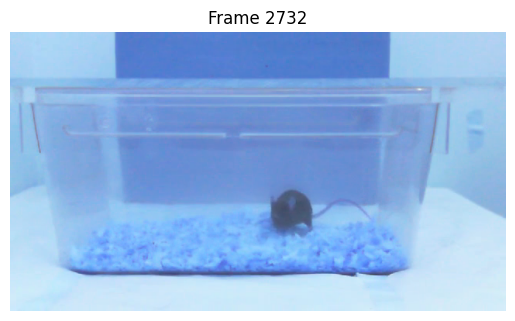

In [4]:
video_path = 'experiments/A-7.mp4'

if not os.path.exists(video_path):
    print(f'No existe el archivo de video en {video_path}')
    # y detenemos la ejecución de la celda con
    raise SystemExit("Stop right there!")
else:
    print(f'Cargando archivo {video_path}')

# se puede analizar el video en python con opencv. Las propiedades del video pueden ser obtenidas con el siguiente código
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
print(ret)
print(cap.get(cv2.CAP_PROP_FPS))
print(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(cap.get(cv2.CAP_PROP_FOURCC))

random_frame = np.random.randint(0, cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Se puede obtener un frame en particular con el siguiente código, y se puede mostrar con matplotlib
cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
ret, frame = cap.read()

fig, ax = plt.subplots()
plt.imshow(frame, cmap='viridis')
plt.axis('off')
plt.title(f'Frame {random_frame}')
plt.show()

cap.release()


In [9]:
import cv2

# Definir la ROI (x, y, ancho, alto)
roi_x, roi_y, roi_w, roi_h = 30, 70, 520, 245

video_path = 'experiments/A-7.mp4'
video_out = 'experiments/A-7_crop.mp4'

# Abrir el video
cap = cv2.VideoCapture(video_path)

# Obtener propiedades del video
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Definir el codec y crear el objeto VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_out, fourcc, fps, (roi_w, roi_h))

# Procesar cada frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Recortar el frame a la ROI
    roi_frame = frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
    
    # Escribir el frame recortado en el nuevo video
    out.write(roi_frame)

# Liberar los objetos
cap.release()
out.release()


In [6]:
import time
# ahora podemos usar este video para analizarlo con deeplabcut rapidamente y ver como se comporta la inferencia en un video corto

video_anal = 'experiments/A-7_crop.mp4'

start_time = time.time()
dlc.analyze_videos(path_config_file, 
                   [video_anal], 
                          videotype='mp4', 
                          shuffle=1, 
                          trainingsetindex=0, 
                          gputouse=None, 
                          save_as_csv=True, 
)

print(f'El análisis de {video_anal} tardó {time.time()-start_time} segundos')

Using snapshot-400000 for model Experimento Olfato-JJ-2024-02-19/dlc-models/iteration-0/Experimento OlfatoFeb19-trainset95shuffle1


/home/juan/miniforge3/envs/deeplabcut/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  experiments/A-7_crop.mp4
Loading  experiments/A-7_crop.mp4
Duration of video [s]:  2693.73 , recorded with  15.0 fps!
Overall # of frames:  40406  found with (before cropping) frame dimensions:  520 244
Starting to extract posture


100%|██████████| 40406/40406 [51:25<00:00, 13.10it/s]


Saving results in experiments...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
El análisis de experiments/A-7_crop.mp4 tardó 3088.4492480754852 segundos


/home/juan/miniforge3/envs/deeplabcut/lib/python3.10/site-packages/deeplabcut/utils/auxiliaryfunctions.py:402: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  DataMachine.to_hdf(dataname, "df_with_missing", format="table", mode="w")


In [8]:
dlc.filterpredictions(path_config_file,
                    [video_anal], 
                    shuffle=1, 
                    trainingsetindex=0, 
                    filtertype='arima',  
                    windowlength=5, 
                    p_bound=0.7, ARdegree=3, MAdegree=1, alpha=0.01, 
                    save_as_csv=True, destfolder=None, 
                    modelprefix='', track_method='', 
                    return_data=False)

Filtering with arima model experiments/A-7_crop.mp4


/home/juan/miniforge3/envs/deeplabcut/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/juan/miniforge3/envs/deeplabcut/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/juan/miniforge3/envs/deeplabcut/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/juan/miniforge3/envs/deeplabcut/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/hom

Saving filtered csv poses!


In [14]:
output_video = '/home/juan/Dropbox/Documentos/Programacion/Ratones Lorena Rela/experiments/C-3_anotado.mp4'

dlc.create_labeled_video(path_config_file, 
                            [output_video], 
                            shuffle=1, 
                            trainingsetindex=0, 
                            filtered=False, 
                            save_frames=False, 
 

                            displayedbodyparts='all', 
 
                            draw_skeleton=False, 
                            trailpoints=0, 


                            videotype='mp4', 

)

Starting to process video: /home/juan/Dropbox/Documentos/Programacion/Ratones Lorena Rela/experiments/C-3_anotado.mp4
Loading /home/juan/Dropbox/Documentos/Programacion/Ratones Lorena Rela/experiments/C-3_anotado.mp4 and data.
Duration of video [s]: 2700.57, recorded with 15.03 fps!
Overall # of frames: 40599 with cropped frame dimensions: 640 360
Generating frames and creating video.


 45%|████▌     | 18330/40599 [07:31<07:45, 47.88it/s]

KeyboardInterrupt: 